# Final Project - Battle of Neigh.
by Frank Ygnacio Rosas

### i. Import main libraries

In [595]:
#importing base libraries 
#to get data
import requests
#for scraping
from bs4 import BeautifulSoup
#base python libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [449]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np # library to handle data in a vectorized manner

In [450]:
import re
import urllib
from IPython.display import Image
from IPython.core.display import HTML 

In [451]:
import matplotlib.pyplot as plt

### Part 1 |  Scrapping information - General Lima DF

#### 1.1. General Wikipedia URL Scrapping

In [452]:
#get the entire html of the url as a str
wikipedia_url = requests.get('https://es.wikipedia.org/wiki/Lima_Metropolitana').text

In [453]:
lima_data = BeautifulSoup(wikipedia_url, 'html.parser') #text to html

In [454]:
info_table = lima_data.find('table', class_ = 'wikitable')
rows_selected = info_table.find_all('tr')

In [455]:
# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
lima_info = []
for row in rows_selected:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    lima_info.append(info)
    
lima_info[:]

[['Ubicación', 'Distrito', 'Población (habitantes )'],
 ['070701', 'Callao', '426\xa0649'],
 ['070702', 'Bellavista', '78\xa0489'],
 ['070703', 'Carmen de La Legua', '43\xa0156'],
 ['070704', 'La Perla', '64\xa0111'],
 ['070705', 'La Punta', '3955'],
 ['070706', 'Mi Perú', '52\xa0722'],
 ['070707', 'Ventanilla', '356\xa0040'],
 ['150101', 'Lima', '276\xa0861'],
 ['150102', 'Ancón', '43\xa0951'],
 ['150103', 'Ate', '638\xa0345'],
 ['150104', 'Barranco', '30\xa0698'],
 ['150105', 'Breña', '77\xa0291'],
 ['150106', 'Carabayllo', '305\xa0963'],
 ['150107', 'Cieneguilla', '47\xa0860'],
 ['150108', 'Chaclacayo', '44\xa0271'],
 ['150109', 'Chorrillos', '330\xa0483'],
 ['150110', 'Comas', '532\xa0403'],
 ['150111', 'El Agustino', '194\xa0474'],
 ['150112', 'Independencia', '220\xa0654'],
 ['150113', 'Jesús María', '73\xa0439'],
 ['150114', 'La Molina', '175\xa0237'],
 ['150115', 'La Victoria', '174\xa0958'],
 ['150116', 'Lince', '51\xa0054'],
 ['150117', 'Los Olivos', '377\xa0532'],
 ['150118'

In [456]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 1.2. Setting Neigh. as Population ("población" in Spanish)

In [457]:
#table (lists of list) to df

lima_info[0][-1] = 'Poblacion'
lima_df = pd.DataFrame(lima_info[1:], columns=lima_info[0])

lima_df.head()

,Ubicación,Distrito,Poblacion
0,070701,Callao,426 649
1,070702,Bellavista,78 489
2,070703,Carmen de La Legua,43 156
3,070704,La Perla,64 111
4,070705,La Punta,3955


#### 1.3. Find latitude and longitude for each Lima city district

In [458]:
geolocator = Nominatim(user_agent="lima_explorer")

In [459]:
lima_df['Distrito'] = lima_df['Distrito'].apply(lambda x: "{}{}".format('Lima, ', x))
lima_df.head()

,Ubicación,Distrito,Poblacion
0,070701,"Lima, Callao",426 649
1,070702,"Lima, Bellavista",78 489
2,070703,"Lima, Carmen de La Legua",43 156
3,070704,"Lima, La Perla",64 111
4,070705,"Lima, La Punta",3955


In [460]:
lima_df['Major_Dist_Coord']= lima_df['Distrito'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
lima_df[['Latitude', 'Longitude']] = lima_df['Major_Dist_Coord'].apply(pd.Series)
#remove column 'Major_Dist_Coord'
lima_df.drop(['Major_Dist_Coord'], axis=1, inplace=True)

In [461]:
#eliminate with space in poblacion data
lima_df['Poblacion'] = lima_df['Poblacion'].str.replace(" ","")
lima_df = lima_df.sort_values(['Poblacion'], axis=0, ascending = True)
lima_df.head(10)

,Ubicación,Distrito,Poblacion,Latitude,Longitude
36,150130,"Lima, San Borja",114 688,-12.096452,-76.995690
28,150122,"Lima, Pachacámac",131 037,-12.251097,-76.906592
42,150136,"Lima, San Miguel",138 226,-12.078656,-77.095283
44,150138,"Lima, Santa María del Mar",1638,-12.401403,-76.775465
34,150128,"Lima, Rímac",167 617,-12.020304,-77.035463
21,150115,"Lima, La Victoria",174 958,-12.073358,-77.016417
20,150114,"Lima, La Molina",175 237,-12.090177,-76.922338
29,150123,"Lima, Pucusana",17 340,-12.482092,-76.797453
17,150111,"Lima, El Agustino",194 474,-12.042052,-76.995714
45,150139,"Lima, Santa Rosa",19 047,-12.035851,-77.086616


#### 1.4. Find latitude and longitude of Lima City

In [462]:
#check the Lima City General Coordinates
address = 'Lima, Peru'
geolocator = Nominatim(user_agent="lima_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Lima City is {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Lima City is -12.0621065, -77.0365256.


### Part 2 |  Listing and Visualizing venues per districts - General Lima Districts Map

#### 2.1. Main ID information and Foursquare Requirements

In [463]:
CLIENT_ID = 'AW532KHX12WPNYVJZ4GRG1HJ1SEOFY5H35LGLLWQQ24SZOZ0' # your Foursquare ID
CLIENT_SECRET = 'F5X1XRL32HAIJCNKOQ3ZADFOTK14AWJBWJCLEHF3LLQOVXSW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AW532KHX12WPNYVJZ4GRG1HJ1SEOFY5H35LGLLWQQ24SZOZ0
CLIENT_SECRET:F5X1XRL32HAIJCNKOQ3ZADFOTK14AWJBWJCLEHF3LLQOVXSW


In [464]:
#Get the neighborhood's latitude and longitude values.

neighborhood_latitude = lima_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = lima_df.loc[0, 'Longitude'] # neighborhood longitude value

In [465]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=AW532KHX12WPNYVJZ4GRG1HJ1SEOFY5H35LGLLWQQ24SZOZ0&client_secret=F5X1XRL32HAIJCNKOQ3ZADFOTK14AWJBWJCLEHF3LLQOVXSW&v=20180605&ll=-12.00365435,-77.11924373751658&radius=1000&limit=100'

#### 2.2. Functions to get districts latitude and longitude inc. venues info

In [466]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [467]:
# function to repeat the exploring process to all the districts in Lima
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                                       CLIENT_SECRET, 
                                                                                                                                       VERSION, 
                                                                                                                                       lat, 
                                                                                                                                       lng, 
                                                                                                                                       radius, 
                                                                                                                                       LIMIT)
            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name'],
                        v['id']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Localidad', 
                                 'Localidad Latitude', 
                                 'Localidad Longitude', 
                                 'Venue', 
                                 'Venue Latitude', 
                                 'Venue Longitude', 
                                 'Venue Category',
                                 'Venue ID']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [468]:
# Use category id 4bf58dd8d48988d16c941735 to only get "food" venues in each district
lima_food_venues = getNearbyVenues(names=lima_df['Distrito'], 
                                     latitudes=lima_df['Latitude'],
                                     longitudes=lima_df['Longitude'],
                                     radius=radius, categoryIds='4d4b7105d754a06374d81259')
lima_food_venues.head()

,Localidad,Localidad Latitude,Localidad Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Lima, San Borja",-12.096452,-76.99569,La Nuez,-12.095357,-76.995255,Pastry Shop,5dd6f8b509dedd00070b3de4
1,"Lima, San Borja",-12.096452,-76.99569,Restaurante Hakka,-12.097483,-77.001969,Chinese Restaurant,591e4b73b1538e79e87bad6f
2,"Lima, San Borja",-12.096452,-76.99569,Starbucks,-12.093799,-76.995626,Coffee Shop,53643300498e567ae5596f8f
3,"Lima, San Borja",-12.096452,-76.99569,Restaurante Xin Yan,-12.088334,-76.996451,Dim Sum Restaurant,5898cb2d34935539da7ee75f
4,"Lima, San Borja",-12.096452,-76.99569,La Panka,-12.090465,-77.004289,Peruvian Restaurant,5b08bd83f15b51002ce429f4


#### 2.3. Scrapping districts segmentation | Five zones

In [469]:
#extracting segmentation of each district in each zone
wikipedia_url_dist = requests.get('https://es.wikipedia.org/wiki/Categor%C3%ADa:Distritos_de_Lima').text
lima_data_dist = BeautifulSoup(wikipedia_url_dist, 'html.parser') #text to html
info_table_dist = lima_data_dist.find('table', class_ = 'nowraplinks')
links = info_table_dist.findAll('a')

In [470]:
districts_and_zone = []
for link in links:
    districts_and_zone.append(link.get('title'))
final_dist_zone = districts_and_zone[3:]
final_dist_zone[18]="Distrito de " + final_dist_zone[18]
final_dist_zone = [string.replace("(aún no redactado)","").replace(" (Lima)","") for string in final_dist_zone]

In [471]:
list_zones = [element for element in final_dist_zone if "Distrito" not in element]
list_index_zones = [final_dist_zone.index(i) for i in list_zones]
pair_index = list(zip(list_index_zones, list_index_zones[1:] + list_index_zones[:1])) 

In [472]:
distDict = {}
for pair in pair_index:
    if pair[1] == 0:
        pair = (pair[0],None)
    else: 
        pass
    distDict[final_dist_zone[pair[0]]]=final_dist_zone[pair[0]+1:pair[1]]

In [473]:
for key in distDict:
    distDict[key]=[val.replace("Distrito de ","").replace("Distrito del ","") for val in distDict[key]]

In [474]:
lima_food_venues["Distrito"]= lima_food_venues["Localidad"].apply(lambda x: x.replace("Lima, ",""))

In [475]:
# color per zone
colors_dict = dict(zip(list_zones,["red","blue","green","orange","yellow"]))

In [476]:
main_list_dfs = []
for key in distDict:
    tempList = distDict[key]
    tempDf = lima_food_venues.query('Distrito in @tempList')
    tempDf["Sector"] = key
    tempDf["sector_color"] = colors_dict[key]
    main_list_dfs.append(tempDf)

C:\Users\FRANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\FRANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [477]:
main_df = pd.concat(main_list_dfs)

In [478]:
main_df.head(7)

,Localidad,Localidad Latitude,Localidad Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Distrito,Sector,sector_color
166,"Lima, Rímac",-12.020304,-77.035463,Manka Mitu (Olla De Barro),-12.023671,-77.032493,Restaurant,5a89d47f178a2a50af879402,Rímac,Centro de Lima,red
167,"Lima, Rímac",-12.020304,-77.035463,Purito Catacaos,-12.024344,-77.036260,Seafood Restaurant,527697e911d2f813ded3b722,Rímac,Centro de Lima,red
168,"Lima, Rímac",-12.020304,-77.035463,Chifa Hoo Wa,-12.026661,-77.034016,Chinese Restaurant,4c6842cd73851b8d4721ba39,Rímac,Centro de Lima,red
169,"Lima, Rímac",-12.020304,-77.035463,Chifa Yon Fu,-12.027328,-77.033331,Cantonese Restaurant,5691d1d938faabbd111febb0,Rímac,Centro de Lima,red
170,"Lima, Rímac",-12.020304,-77.035463,El Rinconcito,-12.028072,-77.034042,Seafood Restaurant,51d5c205498ec498fc1e7a9c,Rímac,Centro de Lima,red
171,"Lima, Rímac",-12.020304,-77.035463,El Loco Pez,-12.023236,-77.031471,Seafood Restaurant,5183eeea498ef05a2d4668e7,Rímac,Centro de Lima,red
172,"Lima, Rímac",-12.020304,-77.035463,Restaurant de Marina y Jcarlos,-12.026230,-77.035590,Peruvian Restaurant,51d1c81b498e991727206311,Rímac,Centro de Lima,red


#### 2.4. Map of each venue by district

* North: orange
* Center (Mid): red
* East: green
* Modern: blue
* South: yellow

In [479]:
# create map of Lima using latitude and longitude values
map_sm = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, color in zip(main_df['Venue Latitude'],
                                  main_df['Venue Longitude'],
                                  main_df['Sector'],
                                  main_df["sector_color"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sm)  
    
map_sm

In case you cannot see the picture:

In [623]:
Image(url= "https://i.ibb.co/Pz1v5Mr/Screenshot-3.png")

### Part 3 | Exploring Results

Percentage of each venue category per lima sector.

In [481]:
df_multiindex = main_df.groupby(['Sector', 'Venue Category']).size().to_frame("cant")

In [482]:
df_grouped=df_multiindex.groupby(level = "Sector")

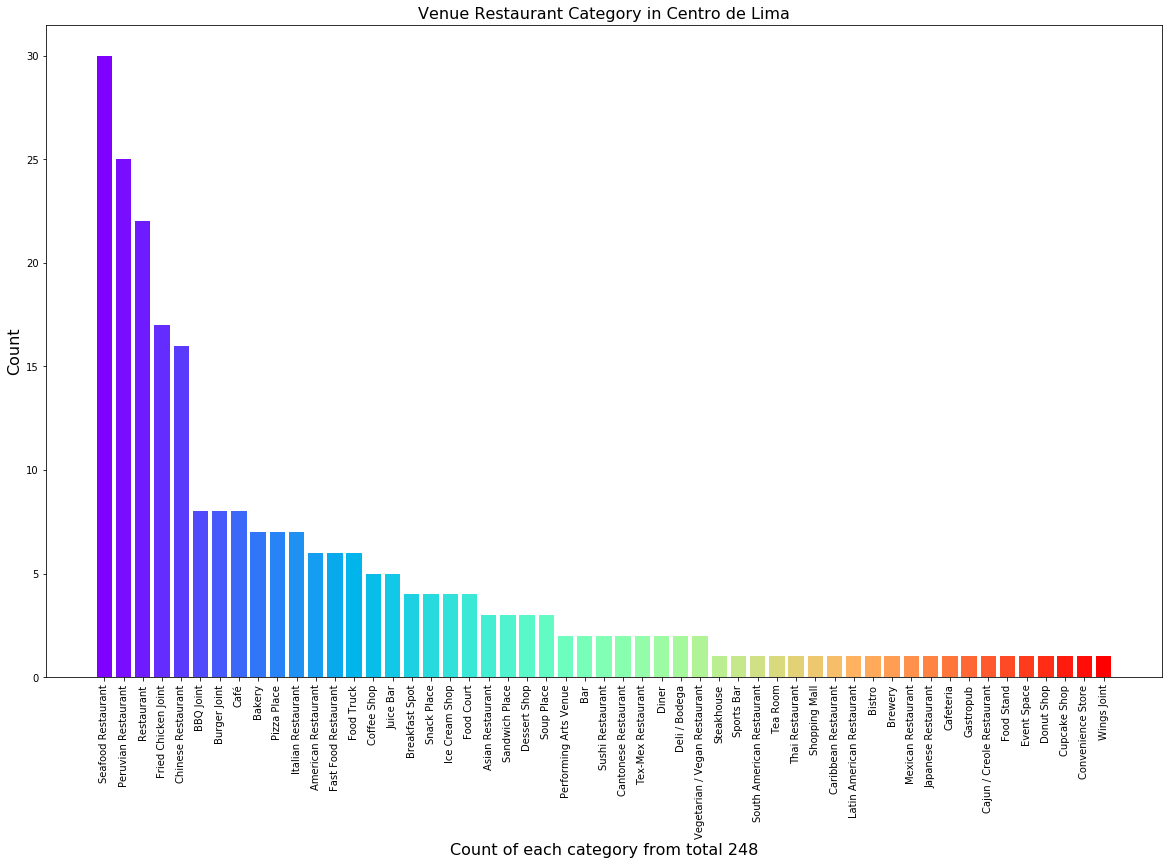

General Info Top 1 venues summary:
                                     cant
Sector         Venue Category            
Centro de Lima Seafood Restaurant  12.10% | Total: 248
************************************************************************************************************************


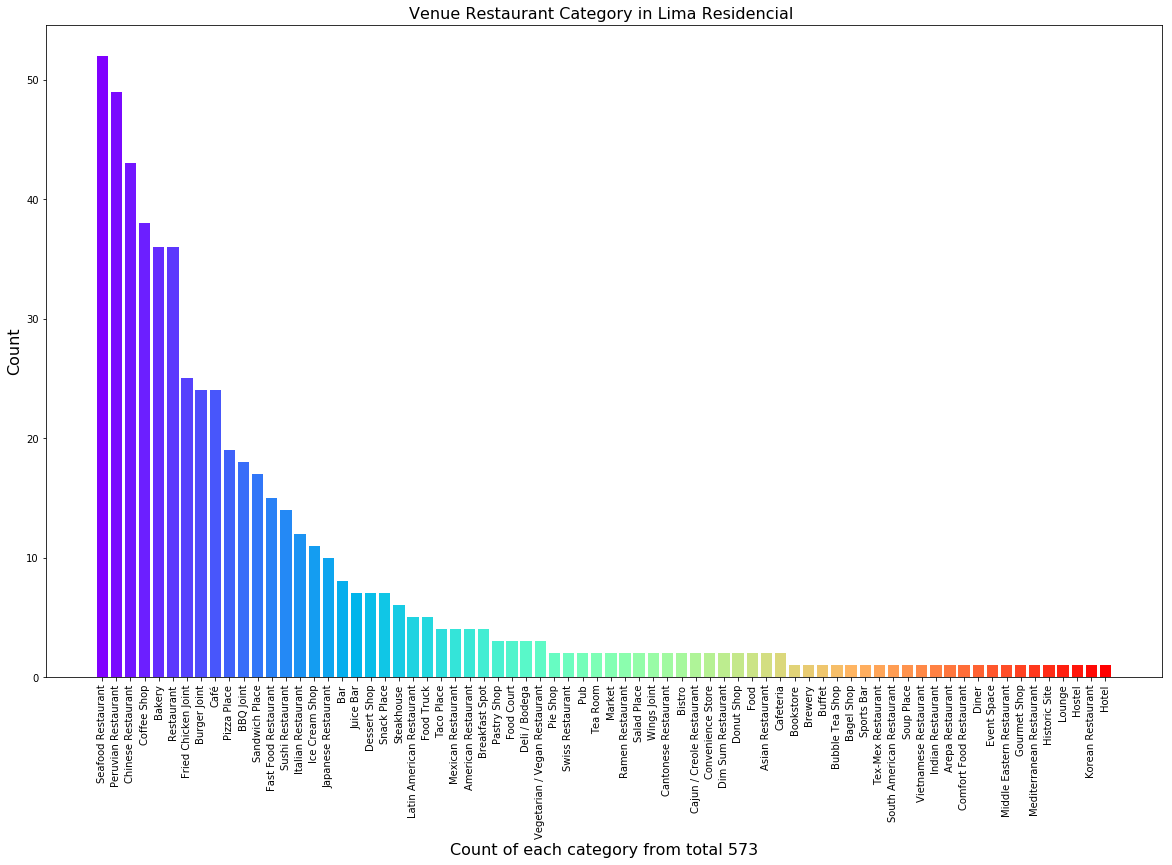

General Info Top 1 venues summary:
                                       cant
Sector            Venue Category           
Lima Residencial  Seafood Restaurant  9.08% | Total: 573
************************************************************************************************************************


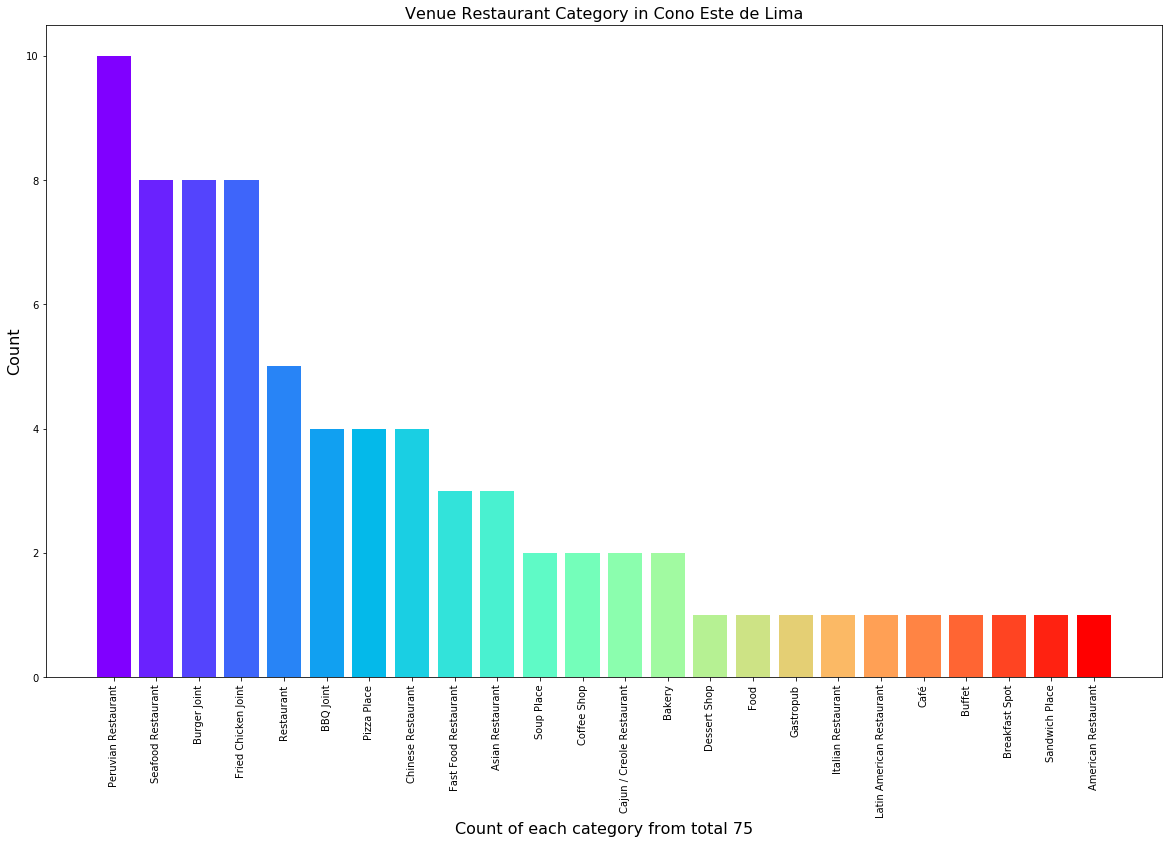

General Info Top 1 venues summary:
                                         cant
Sector            Venue Category             
Cono Este de Lima Peruvian Restaurant  13.33% | Total: 75
************************************************************************************************************************


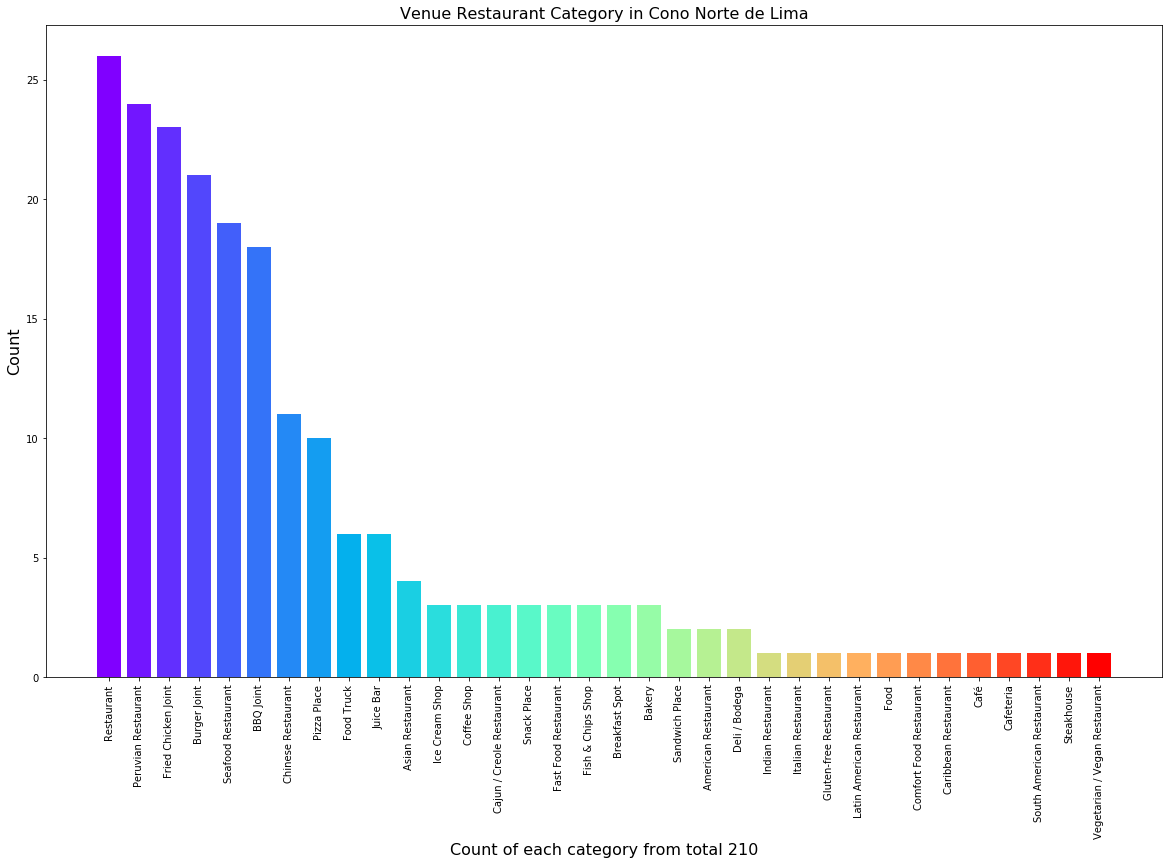

General Info Top 1 venues summary:
                                     cant
Sector             Venue Category        
Cono Norte de Lima Restaurant      12.38% | Total: 210
************************************************************************************************************************


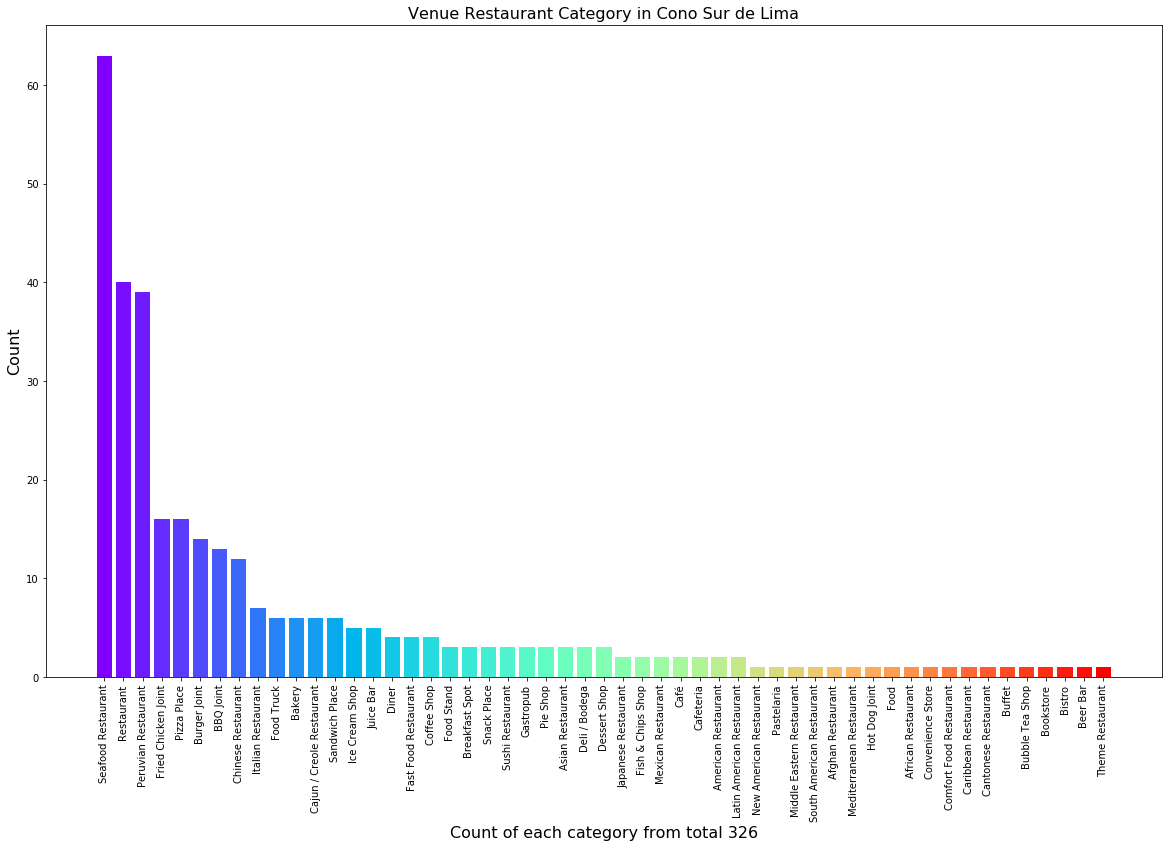

General Info Top 1 venues summary:
                                       cant
Sector           Venue Category            
Cono Sur de Lima Seafood Restaurant  19.33% | Total: 326
************************************************************************************************************************


In [498]:
#selection top N venues for each sector | proportion
top = 1
lst_df_venues_category_selected = []
for zone in list_zones:
    df_result=df_grouped.get_group(zone).sort_values(by="cant",
                                                     ascending=False)
    colors = cm.rainbow(np.linspace(0, 1, len(df_result.index)))
    plt.figure(figsize = (20, 12))
    plt.xticks(rotation = 90)
    plt.xlabel("Count of each category from total {}".format(df_result.sum().values[0]),fontsize = 16)
    plt.ylabel("Count", fontsize = 16)
    plt.title("Venue Restaurant Category in {}".format(zone), fontsize = 16)
    plt.bar(list(df_result.index.get_level_values(level=1)),list(df_result.cant), color = colors)
    plt.show()
    pct_venue_cat_per_zone = df_result/df_result.sum()
    pct_venue_cat_per_zone['cant'] = pct_venue_cat_per_zone['cant'].astype(float).map("{:.2%}".format)
    print("General Info Top {} venues summary:".format(top))
    print(pct_venue_cat_per_zone.head(top),"| Total:",df_result.sum().values[0])
    lst_df_venues_category_selected.append(pct_venue_cat_per_zone.head(top))
    print("***"*40)

In [499]:
df_venues_selected=pd.concat(lst_df_venues_category_selected).reset_index().iloc[:,:2]

In [500]:
df_venues_selected

,Sector,Venue Category
0,Centro de Lima,Seafood Restaurant
1,Lima Residencial,Seafood Restaurant
2,Cono Este de Lima,Peruvian Restaurant
3,Cono Norte de Lima,Restaurant
4,Cono Sur de Lima,Seafood Restaurant


In [501]:
df_10ven_sector = main_df[main_df.set_index(['Sector','Venue Category']).index.isin(df_venues_selected.set_index(['Sector','Venue Category']).index)]

In [516]:
df10sample = df_10ven_sector.groupby("Sector").apply(lambda x: x.sample(n=5))

In [519]:
def getting_venue_rating_and_tip(venueID):

    tempUrl='https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueID,
                                                                                                CLIENT_ID,
                                                                                                CLIENT_SECRET,
                                                                                                VERSION)
    result_temp_venue = requests.get(tempUrl).json()
    
    try:
        final_val_rat = result_temp_venue['response']['venue']['rating']
    except:
        final_val_rat=0
        
    final_val_tip = result_temp_venue['response']['venue']['tips']['count']
    return final_val_rat,final_val_tip

In [520]:
resultDf = df10sample.merge(df10sample["Venue ID"].apply(lambda s: pd.Series({'rating':getting_venue_rating_and_tip(s)[0],
                                                                             'tips':getting_venue_rating_and_tip(s)[1]})),
                            left_index=True, right_index=True)

In [546]:
selectedDf = resultDf.loc[(resultDf[["rating","tips"]]!=0.0).any(axis=1)]

In [622]:
selectedDf

Localidad  Localidad Latitude  \
Sector                                                                     
Centro de Lima    519                     Lima, Lima          -12.062107   
                  1015                   Lima, Lince          -12.086568   
                  1024                   Lima, Lince          -12.086568   
Cono Este de Lima 426   Lima, San Juan de Lurigancho          -11.948751   
                  468              Lima, Santa Anita          -12.223383   
Cono Sur de Lima  1533             Lima, San Bartolo          -12.387071   
                  289                 Lima, Pucusana          -12.482092   
                  858   Lima, San Juan de Miraflores          -12.155852   
Lima Residencial  134               Lima, San Miguel          -12.078656   
                  1227                Lima, San Luis          -12.072356   
                  1235                Lima, San Luis          -12.072356   
                  557                 Lima, Barranco          -12.143959   
                  1507            Lima, Pueblo Libre          -12.076639   

                        Localidad Longitude                         Venue  \
Sector                                                                      
Centro de Lima    519            -77.036526                 PuertoNortePe   
                  1015           -77.036647      El Merlín de Cabo Blanco   
                  1024           -77.036647                    Punto Azul   
Cono Este de Lima 426            -76.977911  El Rinconcito de la Panchita   
                  468            -76.847707                     Las Leñas   
Cono Sur de Lima  1533           -76.777945           Restaurante Chelulo   
                  289            -76.797453              Restaurant Jhony   
                  858            -76.972129           Cevicheria "Dorita"   
Lima Residencial  134            -77.095283          Mi Propiedad Privada   
                  1227           -76.995891                 Mi Cebi-chela   
                  1235           -76.995891                Los Cantaritos   
                  557            -77.020268              Chanfainita Pale   
                  1507           -77.067858                   Don Pedrito   

                        Venue Latitude  Venue Longitude       Venue Category  \
Sector                                                                         
Centro de Lima    519       -12.057745       -77.038553   Seafood Restaurant   
                  1015      -12.088073       -77.047150   Seafood Restaurant   
                  1024      -12.092118       -77.032527   Seafood Restaurant   
Cono Este de Lima 426       -11.944272       -76.981962  Peruvian Restaurant   
                  468       -12.223809       -76.853793  Peruvian Restaurant   
Cono Sur de Lima  1533      -12.389227       -76.777380   Seafood Restaurant   
                  289       -12.481004       -76.798288   Seafood Restaurant   
                  858       -12.154686       -76.968530   Seafood Restaurant   
Lima Residencial  134       -12.087070       -77.092920   Seafood Restaurant   
                  1227      -12.083223       -76.993127   Seafood Restaurant   
                  1235      -12.081889       -76.993291   Seafood Restaurant   
                  557       -12.146788       -77.014418   Seafood Restaurant   
                  1507      -12.087308       -77.072514   Seafood Restaurant   

                                        Venue ID                Distrito  \
Sector                                                                     
Centro de Lima    519   4daf32884df00ee01d34c00f                    Lima   
                  1015  4c740c7cff1fb60c5469f2a7                   Lince   
                  1024  4ba3d856f964a520d86538e3                   Lince   
Cono Este de Lima 426   50c3867ce4b0e77d29fa8312  San Juan de Lurigancho   
                  468   4de0094145dd3eae8763f5a1             Santa Anita   
Cono Sur de L

### Part 4 | Kmeans Clustering - finding new relationships

In [564]:
data_to_model=selectedDf[["rating","tips"]]
Sum_of_squared_distances = []
K = range(1,7)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_to_model)
    Sum_of_squared_distances.append(km.inertia_)

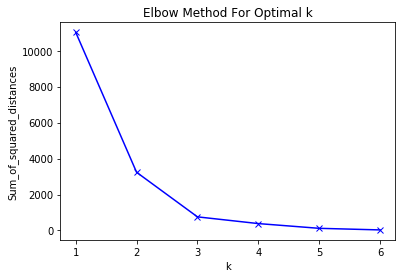

In [565]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Ideal number of clusters: _3_

In [587]:
num_clusters = 3

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(data_to_model)
labels = k_means.labels_

print(labels)

[0 1 0 2 2 2 2 2 0 2 0 0 2]


In [596]:
selectedDf["Labels"] = labels

C:\Users\FRANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [601]:
selectedDf["label_color"]=selectedDf["Labels"].apply(lambda x: "red" if x==0 else ("green" if x==1 else "blue"))

C:\Users\FRANK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [602]:
selectedDf

Localidad  Localidad Latitude  \
Sector                                                                     
Centro de Lima    519                     Lima, Lima          -12.062107   
                  1015                   Lima, Lince          -12.086568   
                  1024                   Lima, Lince          -12.086568   
Cono Este de Lima 426   Lima, San Juan de Lurigancho          -11.948751   
                  468              Lima, Santa Anita          -12.223383   
Cono Sur de Lima  1533             Lima, San Bartolo          -12.387071   
                  289                 Lima, Pucusana          -12.482092   
                  858   Lima, San Juan de Miraflores          -12.155852   
Lima Residencial  134               Lima, San Miguel          -12.078656   
                  1227                Lima, San Luis          -12.072356   
                  1235                Lima, San Luis          -12.072356   
                  557                 Lima, Barranco          -12.143959   
                  1507            Lima, Pueblo Libre          -12.076639   

                        Localidad Longitude                         Venue  \
Sector                                                                      
Centro de Lima    519            -77.036526                 PuertoNortePe   
                  1015           -77.036647      El Merlín de Cabo Blanco   
                  1024           -77.036647                    Punto Azul   
Cono Este de Lima 426            -76.977911  El Rinconcito de la Panchita   
                  468            -76.847707                     Las Leñas   
Cono Sur de Lima  1533           -76.777945           Restaurante Chelulo   
                  289            -76.797453              Restaurant Jhony   
                  858            -76.972129           Cevicheria "Dorita"   
Lima Residencial  134            -77.095283          Mi Propiedad Privada   
                  1227           -76.995891                 Mi Cebi-chela   
                  1235           -76.995891                Los Cantaritos   
                  557            -77.020268              Chanfainita Pale   
                  1507           -77.067858                   Don Pedrito   

                        Venue Latitude  Venue Longitude       Venue Category  \
Sector                                                                         
Centro de Lima    519       -12.057745       -77.038553   Seafood Restaurant   
                  1015      -12.088073       -77.047150   Seafood Restaurant   
                  1024      -12.092118       -77.032527   Seafood Restaurant   
Cono Este de Lima 426       -11.944272       -76.981962  Peruvian Restaurant   
                  468       -12.223809       -76.853793  Peruvian Restaurant   
Cono Sur de Lima  1533      -12.389227       -76.777380   Seafood Restaurant   
                  289       -12.481004       -76.798288   Seafood Restaurant   
                  858       -12.154686       -76.968530   Seafood Restaurant   
Lima Residencial  134       -12.087070       -77.092920   Seafood Restaurant   
                  1227      -12.083223       -76.993127   Seafood Restaurant   
                  1235      -12.081889       -76.993291   Seafood Restaurant   
                  557       -12.146788       -77.014418   Seafood Restaurant   
                  1507      -12.087308       -77.072514   Seafood Restaurant   

                                        Venue ID                Distrito  \
Sector                                                                     
Centro de Lima    519   4daf32884df00ee01d34c00f                    Lima   
                  1015  4c740c7cff1fb60c5469f2a7                   Lince   
                  1024  4ba3d856f964a520d86538e3                   Lince   
Cono Este de Lima 426   50c3867ce4b0e77d29fa8312  San Juan de Lurigancho   
                  468   4de0094145dd3eae8763f5a1             Santa Anita   
Cono Sur de L

In [619]:
new_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label, color in zip(selectedDf['Venue Latitude'],
                                  selectedDf['Venue Longitude'],
                                  selectedDf['Labels'],
                                  selectedDf["label_color"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color=color,
        fill=False,
        fill_color='#FFFFFF',
        fill_opacity=0.7,
        parse_html=False).add_to(new_map)  
    
new_map

In case you cannot see the chart:

In [621]:
Image(url= "https://i.ibb.co/CtVYXq9/Screenshot-1.png")